In [1]:
# Import packages
library(tidyverse)
library(bnlearn)
library(visNetwork)

── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──
✔ ggplot2 3.2.1     ✔ purrr   0.3.2
✔ tibble  2.1.3     ✔ dplyr   0.8.3
✔ tidyr   1.0.0     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.4.0
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Attaching package: ‘bnlearn’

The following object is masked from ‘package:stats’:

    sigma



# User options

In [2]:
# How should discretized data be discretized? Using regression tree and WFD-based boundaries, or terciles?
disc_type = 'terc' # Choose 'terc' or 'rt'

# Read in data

For now, three kinds of data:
- Continuous data
- Discretized data, discretized in two ways:
    * Using regression tree analysis or WFD class boundaries
    * Simple terciles for all variables
    
To do:
- Read in transformed continuous data, so variables are roughly normal (data transformation done roughly). This is only relevant for the cyanobacteria network. Variables in the other network look very roughly normal (examination of histograms by eye).
- In-built discretization algorithm within BN learn, as appropriate discretization will depend on the problem

Lots of the functions in bnlearn can't cope with missing data, so I've had to split the data and BN into two:

1) TP and chl-a and associated data and nodes<br>
2) cyanobacteria and associated data and nodes

This is because the cyanobacteria data only starts in 1997, whilst the TP and chl-a data is available from 1980. This extra step complicates things slightly, as will have to have two separately fit networks, and then chain them together for predictions. But **for starters, just try the whole chain with the TP and chl-a data**.

## Continuous

In [3]:
# Read in continuous data
data_cont = read.csv(file="../data/DataMatrices/Vansjo_Seasonal_Continuous_noCyano.csv",
                     header=TRUE, sep=",", row.names = 1)
                    # row.names = 1 sets the first column as the row names
head(data_cont)

,chla_prevSummer,rainy_days_winter,TP_prevSummer,chla_ES,rain_ES,TP_ES,chla_LS,temp_LS,TP_LS,windDays_under_Q0.4_LS,windDays_over_Q0.6_LS
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1981,16.471230,102,43.57302,7.075000,282.2578,23.58333,9.587500,9.937926,34.08333,41,29
1982,8.331250,105,28.83333,5.466667,151.0062,37.77778,6.229167,10.870945,18.89583,28,47
1983,5.847917,121,28.33681,5.980000,182.7288,31.96000,6.166667,10.877162,26.15000,25,51
1984,6.073333,121,29.05500,10.230000,255.8206,27.36000,11.950000,10.635043,25.69500,35,31
1985,11.090000,138,26.52750,9.977778,236.4939,36.60000,13.333333,9.159237,26.72500,39,40
1986,11.655556,123,31.66250,10.911111,163.4372,33.33333,14.444444,8.234218,34.24444,36,35


## Discrete

In [4]:
# Read in discretized data

# Discretized, class boundaries determined using regression trees, WFD classification boundaries and scatter plots
data_disc_rt = read.csv(file="../data/DataMatrices/Vansjo_Seasonal_Discretized_RegTree_noCyano.csv", header=TRUE, sep=",", row.names = 1)

# Convert from factors to ordered factors: for each columns, assign levels as follows depending
# on how many levels there are (key: number of levels, returns levels to use):

#     factor_li_dict = {2: ['L','H'],
#                      3: ['L','M','H'],
#                      4: ['VL','L','M','H'],
#                      5: ['VL','L','M','H','VH']}

# (n.b. the brackets after data_disc_rt preserves the original indexing; otherwise the row indices are dropped...)
data_disc_rt[] = mutate_all(data_disc_rt, ~ droplevels(factor(., order = TRUE, levels = c("VL", "L", "M", "H", "VH"))))

# Quick look at output
str(data_disc_rt)

head(data_disc_rt)

'data.frame':	37 obs. of  11 variables:
 $ chla_prevSummer       : Ord.factor w/ 2 levels "L"<"H": 1 1 1 1 1 1 1 1 1 1 ...
 $ rainy_days_winter     : Ord.factor w/ 2 levels "L"<"H": 1 1 1 1 1 1 1 2 1 1 ...
 $ TP_prevSummer         : Ord.factor w/ 3 levels "L"<"M"<"H": 3 2 2 2 2 3 3 1 2 2 ...
 $ chla_ES               : Ord.factor w/ 2 levels "L"<"H": 1 1 1 1 1 2 1 2 1 1 ...
 $ rain_ES               : Ord.factor w/ 2 levels "L"<"H": 2 1 1 2 2 1 2 2 1 1 ...
 $ TP_ES                 : Ord.factor w/ 2 levels "L"<"H": 1 2 2 1 2 2 1 2 1 1 ...
 $ chla_LS               : Ord.factor w/ 2 levels "L"<"H": 1 1 1 1 1 1 1 1 2 1 ...
 $ temp_LS               : Ord.factor w/ 2 levels "L"<"H": 1 1 1 1 1 1 1 1 1 1 ...
 $ TP_LS                 : Ord.factor w/ 2 levels "L"<"H": 2 1 1 1 1 2 1 1 1 1 ...
 $ windDays_under_Q0.4_LS: Ord.factor w/ 2 levels "L"<"H": 1 1 1 1 1 1 1 1 1 1 ...
 $ windDays_over_Q0.6_LS : Ord.factor w/ 2 levels "L"<"H": 1 2 2 1 2 2 2 2 2 2 ...


,chla_prevSummer,rainy_days_winter,TP_prevSummer,chla_ES,rain_ES,TP_ES,chla_LS,temp_LS,TP_LS,windDays_under_Q0.4_LS,windDays_over_Q0.6_LS
,<ord>,<ord>,<ord>,<ord>,<ord>,<ord>,<ord>,<ord>,<ord>,<ord>,<ord>
1981,L,L,H,L,H,L,L,L,H,L,L
1982,L,L,M,L,L,H,L,L,L,L,H
1983,L,L,M,L,L,H,L,L,L,L,H
1984,L,L,M,L,H,L,L,L,L,L,L
1985,L,L,M,L,H,H,L,L,L,L,H
1986,L,L,H,H,L,H,L,L,H,L,H


In [5]:
# Discretized, terciles
data_disc_terc = read.csv(file="../data/DataMatrices/Vansjo_Seasonal_Discretized_Terciles.csv",
                          header=TRUE, sep=",", row.names = 1)

# Again, convert factors to ordered factors, using '[]' to preserve row labels in new df            
data_disc_terc[] = mutate_all(data_disc_terc, factor, order=TRUE, levels=c('L','M','H'))
str(data_disc_terc) 

'data.frame':	39 obs. of  17 variables:
 $ chla_prevSummer       : Ord.factor w/ 3 levels "L"<"M"<"H": NA 2 1 1 1 1 1 2 1 2 ...
 $ colour_prevSummer     : Ord.factor w/ 3 levels "L"<"M"<"H": NA NA NA 1 1 NA 2 2 2 2 ...
 $ cyano_prevSummer      : Ord.factor w/ 3 levels "L"<"M"<"H": NA NA NA NA NA NA NA NA NA NA ...
 $ rainy_days_winter     : Ord.factor w/ 3 levels "L"<"M"<"H": NA 1 1 1 1 2 1 1 3 1 ...
 $ TP_prevSummer         : Ord.factor w/ 3 levels "L"<"M"<"H": NA 3 2 2 2 1 2 3 1 2 ...
 $ chla_ES               : Ord.factor w/ 3 levels "L"<"M"<"H": 2 1 1 1 1 1 1 1 2 1 ...
 $ colour_ES             : Ord.factor w/ 3 levels "L"<"M"<"H": NA NA NA 1 NA 2 2 1 1 1 ...
 $ cyano_ES              : Ord.factor w/ 3 levels "L"<"M"<"H": NA NA NA NA NA NA NA NA NA NA ...
 $ rain_ES               : Ord.factor w/ 3 levels "L"<"M"<"H": 2 3 1 1 3 2 1 3 3 1 ...
 $ TP_ES                 : Ord.factor w/ 3 levels "L"<"M"<"H": 3 1 3 3 1 3 3 1 2 2 ...
 $ chla_LS               : Ord.factor w/ 3 levels "L"<"M"<"

# Define DAG structure

Do this manually, based on results of statistical analyses exploring relationships between the data, together with accepted knowledge of the system. Some comments on individual variables:
- Originally included colour, but decided that the relationship was too likely to be due to chance (step change in colour roughly coincides with decrease in cyanobacteria, but potentially just chance)
- Originally also included temperature, as would be nice to include this, but not enough data so drop.

## Whole network

In [6]:
# Create an empty DAG with the desired nodes

nodes = c('TP_ES',
         'TP_LS',
         'TP_prevSummer',
         'chla_ES',
         'chla_LS',
         'chla_prevSummer',
         'cyano_ES',
         'cyano_LS',
         'cyano_prevSummer',
         'rain_ES',
         'rainy_days_winter',
         'windDays_over_Q0.6_LS',
         'windDays_under_Q0.4_LS')

# Were present, but dropped because had too many parents per node given the data:
#          'colour_ES',
#          'colour_LS',
#          'colour_prevSummer',
#          'temp_LS',

dag = empty.graph(nodes)

# Anything removed from the original list needs removing from the data used for fitting cpts
drops = c('temp_LS', 'colour_ES', 'colour_LS', 'colour_prevSummer')
data_S1 = data_disc_rt[ , !(names(data_disc_rt) %in% drops)] # _S1: data for structure 1, discrete
data_S2 = data_cont[ , !(names(data_cont) %in% drops)] # _S1: data for structure 1, continuous

# Manually define the arcs connecting nodes
arcs_matrix = matrix(c('TP_prevSummer','TP_ES',
                       'TP_prevSummer','TP_LS',

                       'TP_ES','chla_ES',           
                       'chla_prevSummer','chla_ES',
                       'rainy_days_winter','chla_ES',
                       'chla_ES','chla_LS',
                       'TP_LS','chla_LS',
                       'windDays_over_Q0.6_LS','chla_LS',

                       'cyano_prevSummer','cyano_ES',
                       'chla_ES','cyano_ES',
#                        'colour_ES','cyano_ES',
#                        'cyano_ES','cyano_LS',
                       'chla_LS','cyano_LS',
                       'windDays_under_Q0.4_LS','cyano_LS'
#                        'temp_LS','cyano_LS',
#                        'colour_LS','cyano_LS',

#                        'colour_prevSummer','colour_ES',
#                        'rain_ES','colour_ES',
#                        'rain_ES','colour_LS',
#                        'colour_ES','colour_LS'
                         ),
                     
                        ncol = 2, byrow = TRUE,
                        dimnames = list(NULL, c("from", "to"))) #assign the DAG structure (as an attribute of asia)

# Assign the structure to the empty graph using arcs, which turns it into a bnlearn object
arcs(dag) = arcs_matrix
dag


  Random/Generated Bayesian network

  model:
   [TP_prevSummer][chla_prevSummer][cyano_prevSummer][rain_ES]
   [rainy_days_winter][windDays_over_Q0.6_LS][windDays_under_Q0.4_LS]
   [TP_ES|TP_prevSummer][TP_LS|TP_prevSummer]
   [chla_ES|TP_ES:chla_prevSummer:rainy_days_winter]
   [chla_LS|TP_LS:chla_ES:windDays_over_Q0.6_LS]
   [cyano_ES|chla_ES:cyano_prevSummer][cyano_LS|chla_LS:windDays_under_Q0.4_LS]
  nodes:                                 13 
  arcs:                                  12 
    undirected arcs:                     0 
    directed arcs:                       12 
  average markov blanket size:           3.08 
  average neighbourhood size:            1.85 
  average branching factor:              0.92 

  generation algorithm:                  Empty 


In [7]:
# Plot the network. Cand do this just using plot(structure), but it doesn't look nice. Instead, use the interactive plotting package visNetwork

# Define a function to create nice interactive plots
plot.network = function(structure, ht="600px")
    {
      nodes.uniq <- unique(c(structure$arcs[,1], structure$arcs[,2]))
      nodes <- data.frame(id = nodes.uniq,
                          label = nodes.uniq,
                          color = "darkturquoise",
                          shadow = FALSE)

      edges <- data.frame(from = structure$arcs[,1],
                          to = structure$arcs[,2],
                          arrows = "to",
                          smooth = TRUE,
                          shadow = FALSE,
                          color = "black")

      return(visNetwork(nodes, edges, height = ht, width = "100%"))
    }

plot.network(dag)

HTML widgets cannot be represented in plain text (need html)

## Just chl-a and TP

In [8]:
nodes = c('TP_ES',
         'TP_LS',
         'TP_prevSummer',
         'chla_ES',
         'chla_LS',
         'chla_prevSummer',
         'rain_ES',
         'rainy_days_winter',
         'windDays_over_Q0.6_LS'
         )

In [9]:
# Create an empty DAG with the desired nodes

nodes = c('TP_ES',
         'TP_LS',
         'TP_prevSummer',
         'chla_ES',
         'chla_LS',
         'chla_prevSummer',
         'rain_ES',
         'rainy_days_winter',
         'windDays_over_Q0.6_LS'
         )

dag_TPChl = empty.graph(nodes)

# Truncate the data so it matches the nodes
data_TPchl_S1 = data_disc_rt[ , (names(data_disc_rt) %in% nodes)] # Call this data for structure 1, abbreviated as '_S1'. Discrete.
data_TPchl_S2 = data_cont[ , (names(data_cont) %in% nodes)] # _S2: data for structure 2, continuous

# Manually define the arcs connecting nodes
arcs_matrix = matrix(c('TP_prevSummer','TP_ES',
                       'TP_prevSummer','TP_LS',
                       'TP_ES','chla_ES',           
                       'chla_prevSummer','chla_ES',
                       'rainy_days_winter','chla_ES',
                       'chla_ES','chla_LS',
                       'TP_LS','chla_LS',
                       'windDays_over_Q0.6_LS','chla_LS'
                         ),
                     
                        ncol = 2, byrow = TRUE,
                        dimnames = list(NULL, c("from", "to"))) #assign the DAG structure (as an attribute of asia)

# Assign the structure to the empty graph using arcs, which turns it into a bnlearn object
arcs(dag_TPChl) = arcs_matrix
dag_TPChl


  Random/Generated Bayesian network

  model:
   [TP_prevSummer][chla_prevSummer][rain_ES][rainy_days_winter]
   [windDays_over_Q0.6_LS][TP_ES|TP_prevSummer][TP_LS|TP_prevSummer]
   [chla_ES|TP_ES:chla_prevSummer:rainy_days_winter]
   [chla_LS|TP_LS:chla_ES:windDays_over_Q0.6_LS]
  nodes:                                 9 
  arcs:                                  8 
    undirected arcs:                     0 
    directed arcs:                       8 
  average markov blanket size:           3.11 
  average neighbourhood size:            1.78 
  average branching factor:              0.89 

  generation algorithm:                  Empty 


In [10]:
# Plot the network. Cand do this just using plot(structure), but it doesn't look nice. Instead, use the interactive plotting package visNetwork
plot.network(dag_TPChl)

HTML widgets cannot be represented in plain text (need html)

# Continuous network


## Fit parameters

In [11]:
# First, convert data type of integers to numeric
data_TPchl_S2[1:ncol(data_TPchl_S2)] = lapply(data_TPchl_S2[1:ncol(data_TPchl_S2)], as.numeric) 

# Fit
fit_cont = bn.fit(dag_TPChl, data_TPchl_S2)
fit_cont


  Bayesian network parameters

  Parameters of node TP_ES (Gaussian distribution)

Conditional density: TP_ES | TP_prevSummer
Coefficients:
  (Intercept)  TP_prevSummer  
   15.6644763      0.4716621  
Standard deviation of the residuals: 5.307613 

  Parameters of node TP_LS (Gaussian distribution)

Conditional density: TP_LS | TP_prevSummer
Coefficients:
  (Intercept)  TP_prevSummer  
    7.4509397      0.7105505  
Standard deviation of the residuals: 4.422258 

  Parameters of node TP_prevSummer (Gaussian distribution)

Conditional density: TP_prevSummer
Coefficients:
(Intercept)  
   29.90655  
Standard deviation of the residuals: 4.915736 

  Parameters of node chla_ES (Gaussian distribution)

Conditional density: chla_ES | TP_ES + chla_prevSummer + rainy_days_winter
Coefficients:
      (Intercept)              TP_ES    chla_prevSummer  rainy_days_winter  
      -22.5378864          0.3102112          0.3539410          0.1603712  
Standard deviation of the residuals: 4.268274 



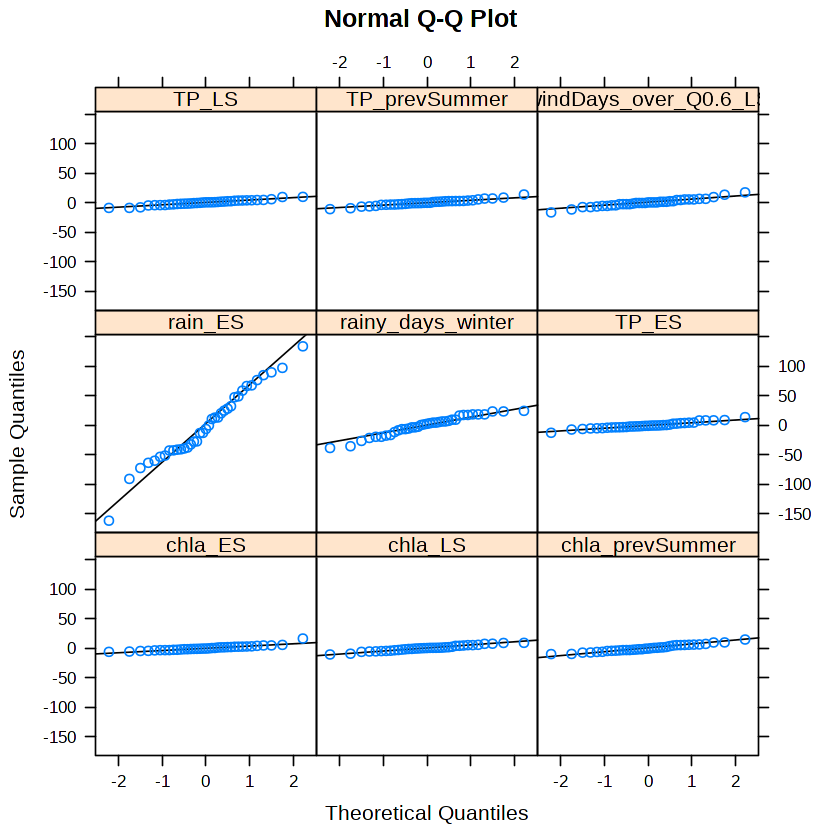

In [12]:
bn.fit.qqplot(fit_cont)

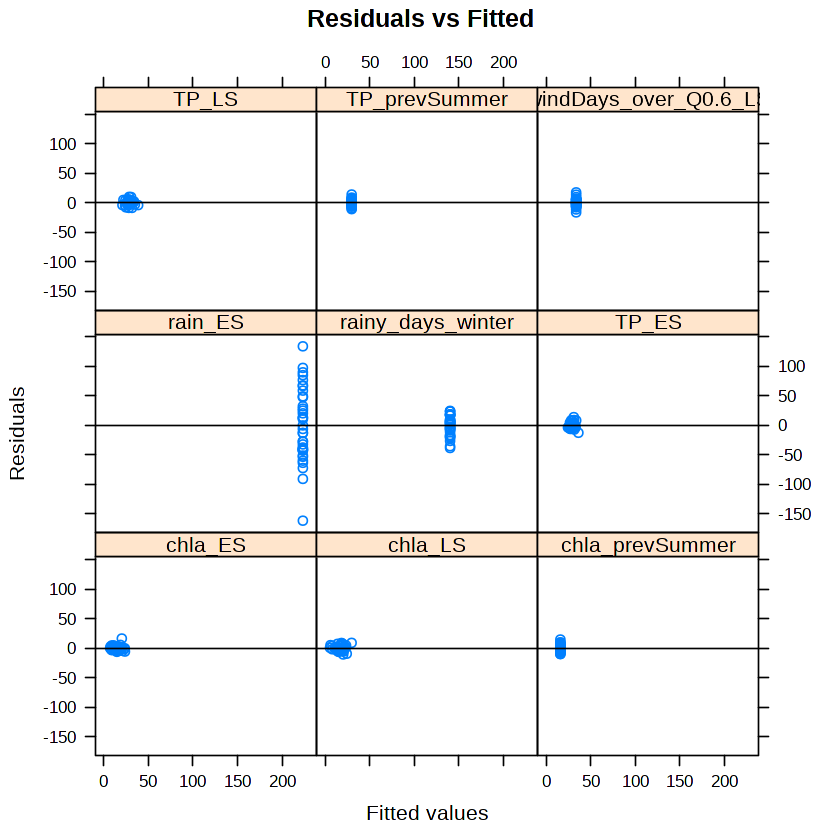

In [13]:
bn.fit.xyplot(fit_cont)

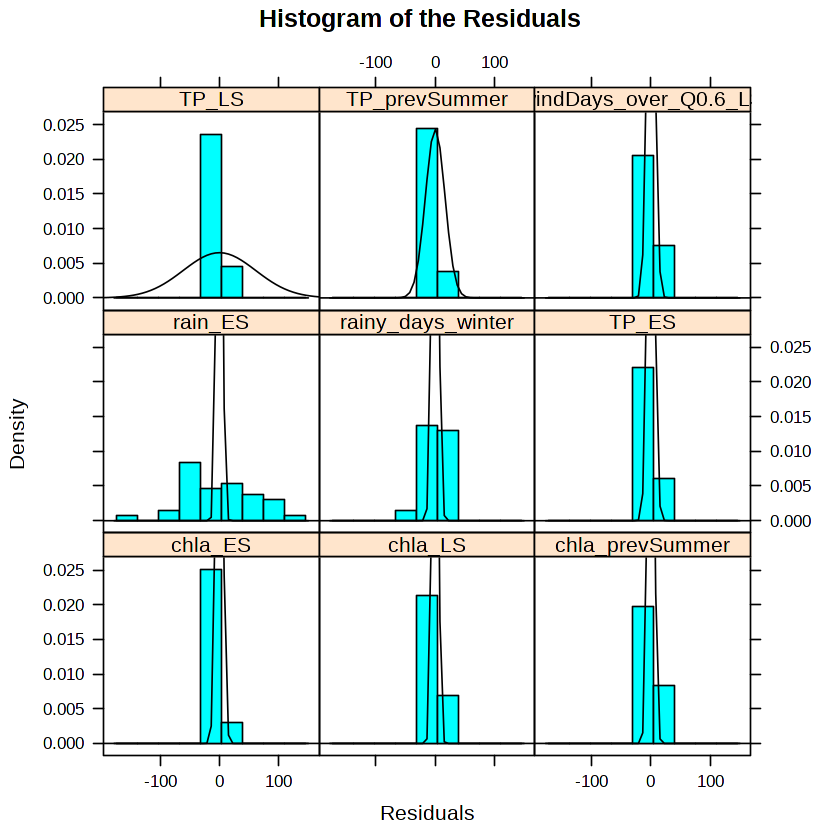

In [14]:
bn.fit.histogram(fit_cont, density=TRUE)

## Code snippet for predicting multiple nodes of gaussian networks at once:


    Just in case others may look for the answer as well, I did solve this problem by using rbmn package. After creating a bn object using bnlearn, I did following:

        my.bn.par <- bn.fit(x = bn.gs, data = dat)

        library("rbmn")

        my.bn.par.rbmn <- bnfit2nbn(my.bn.par)
        print8nbn(my.bn.par.rbmn)
        my.bn.par.mn <- nbn2mn(my.bn.par.rbmn)

        # This is the names vector for my nodes:
        names <- c("A","B","C","D","E")

        # Names of given variables
        obsnames <- c("C","E")

        # Values for given variables
        obsval <- c(0.51,-0.24)

        # Names of variables to be predicted
        prednames <- setdiff(names, obsnames)

        # Then predict all the unknown variables
        print8mn(condi4joint(my.bn.par.mn, par = prednames, pour = obsnames, x2 = obsval))

# Discrete network

##  Fit params of the discrete network

Can do this using two methods in bnlearn, maximum likelihood estimation or bayesian parameter estimation (the latter only for discrete networks). The mle method is a simple frequentist approach setting the relative frequencies as the probability. The Bayesian approach attempts to include some prior information. From https://stackoverflow.com/questions/51945372/bnlearnbn-fit-difference-and-calculation-of-methods-mle-and-bayes:

Using the bayes estimation, the key is the optional iss argument, or "the imaginary sample size used by the bayes method to estimate the conditional probability tables (CPTs) associated with discrete nodes". E.g. for a binary root node X in some network, the bayes option in bnlearn::bn.fit calculates the probability of X = x as (Nx + iss / cptsize) / (N + iss), where N is the number of samples, Nx the number of samples with X = x, and cptsize the size of the CPT of X; in this case cptsize = 2. Thus, iss / cptsize is the number of imaginary observations for each entry in a CPT, as opposed to N, the number of 'real' observations. With iss = 0 you would be getting a maximum likelihood estimate, as you would have no prior imaginary observations. The higher iss with respect to N, the stronger the effect of the prior on your posterior parameter estimates. With a fixed iss and a growing N, the Bayesian estimator and the maximum likelihood estimator converge to the same value. A common rule of thumb is to use a small non-zero iss so that you avoid zero entries in the CPTs, corresponding to combinations that were not observed in the data. Such zero entries could then result in a network which generalizes poorly.

Whichever method is used, if no observations are present within a given 'slice', then probabilities are uniform (using mle, this is only the case when replace.unidentifiable=FALSE; otherwise they are NaNs).


In [15]:
# Get node parameter estimates (n.b. method can be maximum likelihood estimation (default)
# or 'bayes'. Can only use bayesian with discrete. Then also use the iss kwarg.
fit_disc_mle = bn.fit(dag_TPChl, data_TPchl_S1, method='mle',
                        replace.unidentifiable=TRUE) # replace.unidentifiable sets uniform distributions across states where have no observations. Otherwise they are NaNs, which can lead to predict probs
# fit_disc_mle

In [16]:
fit_disc_bys = bn.fit(dag_TPChl, data_TPchl_S1, method='bayes',
                      iss = 1)
fit_disc_bys


  Bayesian network parameters

  Parameters of node TP_ES (ordinal distribution)

Conditional probability table:
 
     TP_prevSummer
TP_ES         L         M         H
    L 0.8409091 0.6224490 0.2209302
    H 0.1590909 0.3775510 0.7790698

  Parameters of node TP_LS (ordinal distribution)

Conditional probability table:
 
     TP_prevSummer
TP_LS          L          M          H
    L 0.97727273 0.62244898 0.15116279
    H 0.02272727 0.37755102 0.84883721

  Parameters of node TP_prevSummer (ordinal distribution)

Conditional probability table:
         L         M         H 
0.1929825 0.4298246 0.3771930 

  Parameters of node chla_ES (ordinal distribution)

Conditional probability table:
 
, , chla_prevSummer = L, rainy_days_winter = L

       TP_ES
chla_ES           L           H
      L 0.500000000 0.597560976
      H 0.500000000 0.402439024

, , chla_prevSummer = H, rainy_days_winter = L

       TP_ES
chla_ES           L           H
      L 0.944444444 0.055555556
      H 0.05

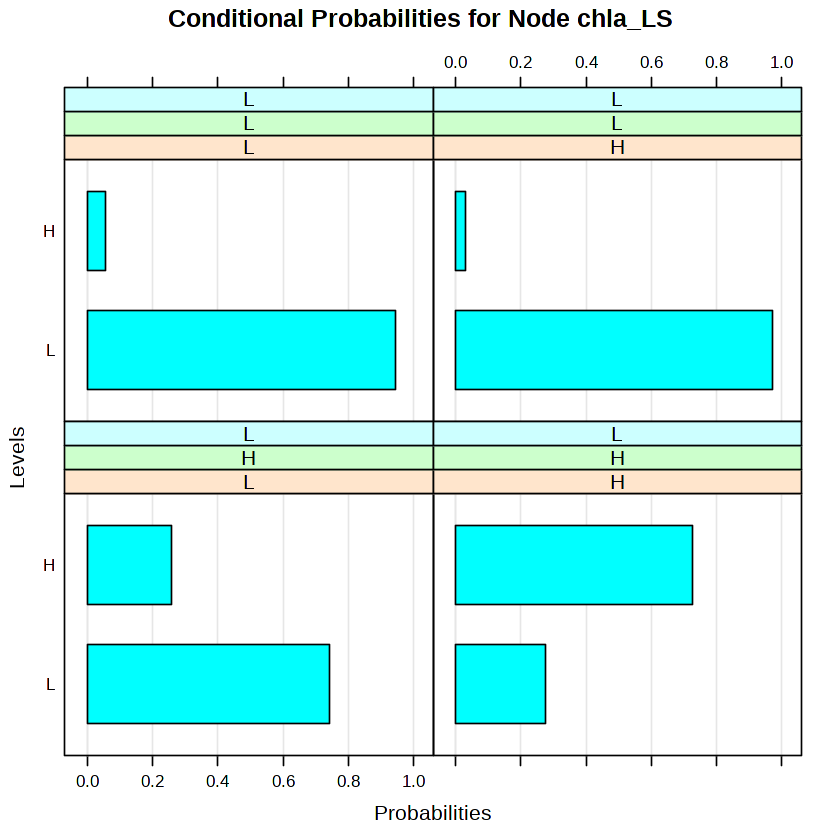

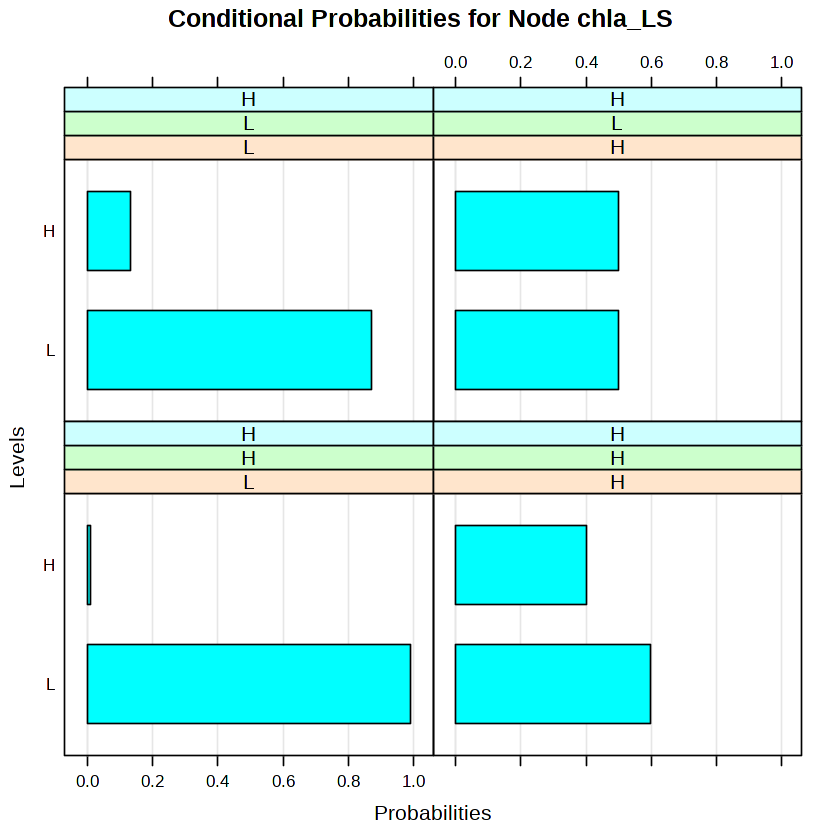

In [17]:
bn.fit.barchart(fit_disc_bys$chla_LS)

## Predicting with the discrete network

Prediction is the process of calculating a probability distribution over one or more variables whose values we would like to know, given information (evidence) we have about some other variables.

The task of predicting a discrete variable is often referred to as Classification in line with other approaches. For a continuous variable C a prediction will contain both a Mean and a Variance. The task of predicting a continuous variable is often referred to as Regression in line with other approaches.

In bnlearn, the predict() function returns the predicted values for a specified node, given the data specified by "data" and the fitted network. Predicted values can be computed using two methods:

1) **method = "parents"**: the predicted values are computed by plugging in the new values for the parents of "node" in the local probability distribution of node extracted from "fitted".

2) **method = "bayes-lw"**: the predicted values are computed by averaging likelihood weighting simulations performed using all the available nodes as evidence (with the exception of the node whose values we are predicting). The number of random samples which are averaged for each new observation is controlled by the n optional argument; the default is 500. If the variable being predicted is discrete, the predicted level is that with the highest conditional probability. If the variable is continuous, the predicted value is the expected value of the conditional distribution. The variables that are used to compute the predicted values can be specified with the "from" optional argument; the default is to use all the relevant variables from the data. Note that the predicted values will differ in each call to predict() since this method is based on a stochastic simulation.

Things for the future:
- When making predictions with a Bayesian network (or any other approach), it is important to know whether the new data we are making predictions on is consistent with our model. If our model is built on historic data that no longer reflects reality, should we trust the predictions? In order to verify that our Inputs are consistent with our model, we can use Anomaly detection. i.e. Before we make a prediction, we can calculate an anomaly score based on our Inputs. If this score looks normal we can continue to make the prediction. If it looks abnormal then we need to think again.

For now, lets try predicting TP_ES for 2017 using both methods. It has just one parent (TP_prev_summ).

In [18]:
# Extract data for 2017
data_2017 = data_TPchl_S1[37,]                 
data_2017

,chla_prevSummer,rainy_days_winter,TP_prevSummer,chla_ES,rain_ES,TP_ES,chla_LS,TP_LS,windDays_over_Q0.6_LS
,<ord>,<ord>,<ord>,<ord>,<ord>,<ord>,<ord>,<ord>,<ord>
2017,L,L,L,H,L,L,L,L,H


In [19]:
# Predict using just the parent nodes of TP_ES
pred_TP_ES_2017 = predict(fit_disc_bys, data=data_2017, node='TP_ES', method='parents', prob=TRUE)
attr(pred_TP_ES_2017, "prob")

print("predicted value:")
pred_TP_ES_2017

L,0.8409091
H,0.1590909


[1] "predicted value:"


[1] L
attr(,"prob")
       [,1]
L 0.8409091
H 0.1590909
Levels: L < H

In [20]:
# Predict using the whole network. By increasing n from the default 500, we get less variability in the output due to sampling.
pred_TP_ES_2017 = predict(fit_disc_bys, data=data_2017, node='TP_ES', method="bayes-lw", prob=TRUE, n=10000)
attr(pred_TP_ES_2017, "prob")

print("predicted value:")
pred_TP_ES_2017

L,0.8716099
H,0.1283901


[1] "predicted value:"


[1] L
attr(,"prob")
       [,1]
L 0.8716099
H 0.1283901
Levels: L < H

Same again, but for chl-a_ES, which has 3 parent nodes:

In [21]:
# Predict using just the parent nodes
pred_chla_ES_2017 = predict(fit_disc_bys, data=data_2017, node='chla_ES', method='parents', prob=TRUE)
attr(pred_chla_ES_2017, "prob")

print("predicted value:")
pred_chla_ES_2017

L,0.5
H,0.5


[1] "predicted value:"


[1] L
attr(,"prob")
  [,1]
L  0.5
H  0.5
Levels: L < H

In [22]:
# chla_ES, predict using all nodes
pred_chla_ES_2017 = predict(fit_disc_bys, data=data_2017, node='chla_ES', method='bayes-lw', prob=TRUE, n=10000)
attr(pred_chla_ES_2017, "prob")

print("predicted value:")
pred_chla_ES_2017

L,0.4661792
H,0.5338208


[1] "predicted value:"


[1] H
attr(,"prob")
       [,1]
L 0.4661792
H 0.5338208
Levels: L < H

**Comments**:
There's a fairly big difference between the probabilities for predicted chl-a between methods used in 'predict'. I would gues sthat the 'bayes-lw' method is better, as it includes the wider network?

Interesting that for chl-a all the parent nodes are class low, yet chl-a is 'M' (43:57 L:M), i.e. the network will never predict low chl-a status.

For predictive performance combined with cross validation, see second half of:
http://www.bnlearn.com/examples/xval/

In order to assess the performance of a Bayesian network, in terms of prediction, we can use the same techniques that are found in other approaches. These are typically split into classification metrics for evaluating the prediction performance of a discrete variable, and regression metrics for continuous.

Classification metrics.
- Accuracy: simply the percentage of predictions the model got correct
- Confusion matrix: how well the model performed for each state of the discrete variable. There are cells in the matrix for each combination of actual vs. predicted values. Each cell displays a count, which is the number of times the predicted value matched the actual value, or probability instead (cell count/row count) (looks a bit like a tertiary plot to me...) (https://www.bayesserver.com/docs/charts/confusion-matrix). See lift charts too.

# Cross validation to compute predictive error

See http://www.bnlearn.com/examples/xval/ for details.

Returns an object of class bn.kcv or bn.kcv.list (the latter if the cross validation is run multiple times, e.g. to work out an average score). Objects contained within this are documented here: https://rdrr.io/cran/bnlearn/man/bn.kcv.class.html

The dataset used for training and evaluation cannot contain NaNs, therefore can't use the same one as used above. Don't want to just drop NaNs, as that would be loads of the TP and chl-a data. Instead, decide to split the data into two dataframes, one for TP and chl-a, one for cyano. Patch the data where appropriate, or drop NaNs.

Then also need two separate BNs, one to fit TP and chl-a, another for cyano that takes chl-a estimates from network 1 as input. Getting complicated... Lets just try to get one BN working for now, that predicts TP and chl-a...

Two network structures are said to belong to the same equivalence class if they represent the same set of probability distributions. A scoring function which assigns the same score to networks in the same equivalence class is score equivalent.

Intro to scoring here, from theoretical point of view: https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3439716/


Choice of score to use in bnlearn:
- factorized normalized maximum likelihood (fNML) shown to perform well when sample sizes are relatively small (Liu et al., 2012; https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3439716/)

## General settings applicable to all

In [127]:
k = nrow(data_TPchl_S1)
n_runs = 20

## Discrete networks

Prediction error is used to evaluate discrete networks (see more info under 'Prediction with the discrete network', above

In [104]:
xval_TPes = bn.cv(data = data_TPchl_S1,    # The data set the BN will be estimated from
             bn = dag_TPChl,          # Provide a fixed network structure here, rather than a structure learning algorithm
             method = 'k-fold',       # Choose from "k-fold" (default), "custom-fold" or "hold-out",
             k = k,
             runs = n_runs,               # The number of times the cross validation is run
             loss = "pred-lw",        # loss function to evaluate GoF
             fit = 'bayes',           # the fitting method (e.g. 'mle' or 'bayes') to fit the BN parameters
             loss.args = list(target="TP_ES", from=c("chla_prevSummer","TP_prevSummer","rainy_days_winter")) # Target node to predict. Could include from="..." to include list of nodes to take into account when making prediction
#             fit.args = list('iss'=1) # e.g. iss if using 'bayes' fitting method
            )
xval_TPes


  k-fold cross-validation for Bayesian networks

  target network structure:
   [TP_prevSummer][chla_prevSummer][rain_ES][rainy_days_winter]
   [windDays_over_Q0.6_LS][TP_ES|TP_prevSummer][TP_LS|TP_prevSummer]
   [chla_ES|TP_ES:chla_prevSummer:rainy_days_winter]
   [chla_LS|TP_LS:chla_ES:windDays_over_Q0.6_LS]
  number of folds:                       37 
  loss function:                         Classification Error (Posterior, disc.) 
  training node:                         TP_ES 
  number of runs:                        50 
  average loss over the runs:            0.2702703 
  standard deviation of the loss:        0 


In [25]:
OBS = unlist(lapply(xval_TPes[[1]], `[[`, "observed"))
PRED = unlist(lapply(xval_TPes[[1]], `[[`, "predicted"))
str(OBS)
str(PRED)
table(OBS, PRED)

 Factor w/ 2 levels "L","H": 1 2 1 2 2 2 2 1 1 2 ...
 Factor w/ 2 levels "L","H": 1 1 1 2 1 2 2 1 1 2 ...


   PRED
OBS  L  H
  L 16  3
  H  7 11

In [114]:
xval_TPls = bn.cv(data = data_TPchl_S1,    # The data set the BN will be estimated from
             bn = dag_TPChl,          # Provide a fixed network structure here, rather than a structure learning algorithm
             method = 'k-fold',       # Choose from "k-fold" (default), "custom-fold" or "hold-out",
             k = k,
             runs = n_runs,               # The number of times the cross validation is run
             loss = "pred-lw",        # loss function to evaluate GoF
             fit = 'bayes',           # the fitting method (e.g. 'mle' or 'bayes') to fit the BN parameters
             loss.args = list(target="TP_LS", from=c("windDays_over_Q0.6_LS","chla_prevSummer","TP_prevSummer","rainy_days_winter"))
#             fit.args = list('iss'=1) # e.g. iss if using 'bayes' fitting method
            )
xval_TPls


  k-fold cross-validation for Bayesian networks

  target network structure:
   [TP_prevSummer][chla_prevSummer][rain_ES][rainy_days_winter]
   [windDays_over_Q0.6_LS][TP_ES|TP_prevSummer][TP_LS|TP_prevSummer]
   [chla_ES|TP_ES:chla_prevSummer:rainy_days_winter]
   [chla_LS|TP_LS:chla_ES:windDays_over_Q0.6_LS]
  number of folds:                       37 
  loss function:                         Classification Error (Posterior, disc.) 
  training node:                         TP_LS 
  number of runs:                        10 
  average loss over the runs:            0.2162162 
  standard deviation of the loss:        0 


In [27]:
OBS = unlist(lapply(xval_TPls[[1]], `[[`, "observed"))
PRED = unlist(lapply(xval_TPls[[1]], `[[`, "predicted"))
str(OBS)
str(PRED)
table(OBS, PRED)

 Factor w/ 2 levels "L","H": 2 2 2 1 1 1 1 2 1 1 ...
 Factor w/ 2 levels "L","H": 2 1 2 1 1 1 1 2 2 1 ...


   PRED
OBS  L  H
  L 17  2
  H  6 12

In [108]:
xval_chla_es = bn.cv(data = data_TPchl_S1,    # The data set the BN will be estimated from
             bn = dag_TPChl,          # Provide a fixed network structure here, rather than a structure learning algorithm
             method = 'k-fold',       # Choose from "k-fold" (default), "custom-fold" or "hold-out",
             k = k,
             runs = n_runs,               # The number of times the cross validation is run
             loss = "pred-lw",        # loss function to evaluate GoF
             fit = 'bayes',           # the fitting method (e.g. 'mle' or 'bayes') to fit the BN parameters
             loss.args = list(target="chla_ES", from=c("chla_prevSummer","TP_prevSummer","rainy_days_winter")) # Target node to predict. Could include from="..." to include list of nodes to take into account when making prediction
#             fit.args = list('iss'=1) # e.g. iss if using 'bayes' fitting method
            )
xval_chla_es


  k-fold cross-validation for Bayesian networks

  target network structure:
   [TP_prevSummer][chla_prevSummer][rain_ES][rainy_days_winter]
   [windDays_over_Q0.6_LS][TP_ES|TP_prevSummer][TP_LS|TP_prevSummer]
   [chla_ES|TP_ES:chla_prevSummer:rainy_days_winter]
   [chla_LS|TP_LS:chla_ES:windDays_over_Q0.6_LS]
  number of folds:                       37 
  loss function:                         Classification Error (Posterior, disc.) 
  training node:                         chla_ES 
  number of runs:                        10 
  average loss over the runs:            0.3702703 
  standard deviation of the loss:        0.02863108 


In [29]:
OBS = unlist(lapply(xval_chla_es[[1]], `[[`, "observed"))
PRED = unlist(lapply(xval_chla_es[[1]], `[[`, "predicted"))
str(OBS)
str(PRED)
table(OBS, PRED)

 Factor w/ 2 levels "L","H": 2 2 1 2 2 2 2 2 2 2 ...
 Factor w/ 2 levels "L","H": 1 2 2 2 2 1 2 2 1 2 ...


   PRED
OBS  L  H
  L  6  5
  H  9 17

In [31]:
xval_chla_ls = bn.cv(data = data_TPchl_S1,    # The data set the BN will be estimated from
             bn = dag_TPChl,          # Provide a fixed network structure here, rather than a structure learning algorithm
             method = 'k-fold',       # Choose from "k-fold" (default), "custom-fold" or "hold-out",
             k = k,
             runs = n_runs,               # The number of times the cross validation is run
             loss = "pred-lw",        # loss function to evaluate GoF
             fit = 'bayes',           # the fitting method (e.g. 'mle' or 'bayes') to fit the BN parameters
             loss.args = list(target="chla_LS", from=c("windDays_over_Q0.6_LS","chla_prevSummer","TP_prevSummer","rainy_days_winter")) # Target node to predict. Could include from="..." to include list of nodes to take into account when making prediction
#             fit.args = list('iss'=1) # e.g. iss if using 'bayes' fitting method
            )
xval_chla_ls


  k-fold cross-validation for Bayesian networks

  target network structure:
   [TP_prevSummer][chla_prevSummer][rain_ES][rainy_days_winter]
   [windDays_over_Q0.6_LS][TP_ES|TP_prevSummer][TP_LS|TP_prevSummer]
   [chla_ES|TP_ES:chla_prevSummer:rainy_days_winter]
   [chla_LS|TP_LS:chla_ES:windDays_over_Q0.6_LS]
  number of folds:                       37 
  loss function:                         Classification Error (Posterior, disc.) 
  training node:                         chla_LS 
  number of runs:                        10 
  average loss over the runs:            0.2162162 
  standard deviation of the loss:        0 


In [32]:
OBS = unlist(lapply(xval_chla_ls[[1]], `[[`, "observed"))
PRED = unlist(lapply(xval_chla_ls[[1]], `[[`, "predicted"))
str(OBS)
str(PRED)
table(OBS, PRED)

 Factor w/ 2 levels "L","H": 1 1 1 1 1 1 1 2 1 2 ...
 Factor w/ 2 levels "L","H": 1 1 1 1 1 1 1 2 1 2 ...


   PRED
OBS  L  H
  L 23  2
  H  6  6

In [ ]:
plot(xval_TPes, xval_TPls, xval_chla_es, xval_chla_ls,
    xlab = c("TP_ES", "TP_LS", "chla_ES", "chla_LS"))

### Comments

**Poor predictive performance for chl-a:**

Early summer:
  average loss over the runs:            0.6243243 
  standard deviation of the loss:        0.04118605 

Late summer:
  average loss over the runs:            0.4324324 
  standard deviation of the loss:        0 #(Suspicious!!)

My first thought is that it could be improved by reducing the number of classes (e.g. early summer chl-a has 3 classes, but only 7 observations in the 'high chl-a' class. Likewise, late summer chl-a only has 6 obs in the 'low chl-a' class. This is NOT much for training the network with! So unsurprising that it isn't good at predicting either. Could therefore try decreasing to just two classes:

chl-a_ES: Merge moderate and poor ecological status, so just have two classes with boundary at 10.5
chl-a_LS: Merge good and moderate ecological status (as almost never good anyway), with one boundary at 20.0

These will still be unbalanced, but really need to stick to WFD-relevant classifications...

**Updated boundaries**:
Yes, statistics are better. Though for late summer, when the observed was high, the predicted was 50% low, 50% high, so not great...

**Had a look at whether it's worth having wind in for late summer chl-a**:
With it in: error 0.22 ('ish) (and high obs have 50:50 of being predicted high)
Without it, not changing the network structure, just the params used to predict chl-a: 0.36 (and high obs never predicted to be high)
Without it, changed network structure: 0.28

i.e. conclude that it is worth having in.

## Continuous networks

From the docs: Predictive correlation and MSE are used to evaluate Gaussian Bayesian networks in the same way as prediction error is used to evaluate discrete ones. bn.cv() implements the following loss arguments:

  "cor-lw" = "Predictive Correlation (Posterior, Gauss.)", used with predict(..., method = "parents")<br>
  "cor-lw-cg" = "Predictive Correlation (Posterior, cond. Gauss.)", from predict(..., method = "bayes-lw")<br>
  "mse" = "Mean Squared Error", from predict(..., method = "parents")<br>
  "mse-lw" = "Mean Squared Error (Posterior, Gauss.)", from predict(..., method = "bayes-lw")<br>
  "mse-lw-cg" = "Mean Squared Error (Posterior, cond. Gauss.)"
  
Not sure what the conditional gaussian option does??

### TP, early summer

In [161]:
set.seed(1)
xval_TPes_cont_corr = bn.cv(data = data_TPchl_S2,    # The data set the BN will be estimated from
             bn = dag_TPChl,          # Provide a fixed network structure here, rather than a structure learning algorithm
             method = 'k-fold',       # Choose from "k-fold" (default), "custom-fold" or "hold-out",
             k = 20,
             runs = 1,               # The number of times the cross validation is run
             loss = "cor-lw",        # loss function to evaluate GoF
             fit = 'mle',           # the fitting method (e.g. 'mle' or 'bayes') to fit the BN parameters
             loss.args = list(target="TP_ES", from=c("chla_prevSummer","TP_prevSummer","rainy_days_winter")), # Target node to predict. Could include from="..." to include list of nodes to take into account when making prediction
            fit.args = list(replace.unidentifiable=TRUE) # Uidentifiable parameters are replaced by zeroes
            )
xval_TPes_cont_corr


  k-fold cross-validation for Bayesian networks

  target network structure:
   [TP_prevSummer][chla_prevSummer][rain_ES][rainy_days_winter]
   [windDays_over_Q0.6_LS][TP_ES|TP_prevSummer][TP_LS|TP_prevSummer]
   [chla_ES|TP_ES:chla_prevSummer:rainy_days_winter]
   [chla_LS|TP_LS:chla_ES:windDays_over_Q0.6_LS]
  number of folds:                       20 
  loss function:                         
                                       Predictive Correlation (Posterior, Gauss.) 
  training node:                         TP_ES 
  expected loss:                         0.2353388 


In [77]:
# Make dataframe of observed and predicted, with one column for each member of xval predictions
obs = unlist(lapply(xval_TPes_cont_corr[[1]], `[[`, "observed"))

df = data.frame(obs)

for (i in seq_along(xval_TPes_cont_corr[])){
    sim = unlist(lapply(xval_TPes_cont_corr[[i]], `[[`, "predicted"))
    name = sprintf("pred_%i", i)
    df[[i+1]] = sim
    names(df)[[i+1]] = name
    }

head(df)

obs,pred_1,pred_2,pred_3,pred_4,pred_5,pred_6,pred_7,pred_8,pred_9,pred_10
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
30.80000,29.87454,27.95067,30.66102,29.82095,29.66321,26.38632,31.66890,30.80757,28.52495,32.40594
31.33333,33.00826,32.98530,31.32893,27.72252,31.99805,30.68449,27.32865,28.03579,27.04959,29.17083
24.46667,32.28463,29.53888,40.72548,30.96960,40.09698,33.21653,32.00230,30.31960,32.58077,29.43390
21.73333,26.71106,30.97995,29.14211,31.22950,30.24534,24.76478,39.22538,27.49424,24.71462,33.55465
20.91667,27.01262,31.80045,27.91209,29.58347,26.32553,27.78839,30.75447,30.67564,30.58317,30.07073
34.66667,30.83262,34.30643,30.69920,29.95467,29.26026,29.64011,29.39957,25.60180,32.09167,30.95946


In [195]:
# Mean square error
xval_TPes_cont_mse = bn.cv(data = data_TPchl_S2,    # The data set the BN will be estimated from
             bn = dag_TPChl,          # Provide a fixed network structure here, rather than a structure learning algorithm
             method = 'k-fold',       # Choose from "k-fold" (default), "custom-fold" or "hold-out",
#              k = 20,
             runs = 10,               # The number of times the cross validation is run
             loss = "mse-lw",        # loss function to evaluate GoF
             fit = 'mle',           # the fitting method (e.g. 'mle' or 'bayes') to fit the BN parameters
             loss.args = list(target="TP_ES", from=c("chla_prevSummer","TP_prevSummer","rainy_days_winter")), # Target node to predict. Could include from="..." to include list of nodes to take into account when making prediction
             fit.args = list(replace.unidentifiable=TRUE) # Uidentifiable parameters are replaced by zeroes
            )
xval_TPes_cont_mse

mse = attr(xval_TPes_cont_mse,"mean")
rmse = sqrt(mse)
print(sprintf('rmse: %f', rmse))


  k-fold cross-validation for Bayesian networks

  target network structure:
   [TP_prevSummer][chla_prevSummer][rain_ES][rainy_days_winter]
   [windDays_over_Q0.6_LS][TP_ES|TP_prevSummer][TP_LS|TP_prevSummer]
   [chla_ES|TP_ES:chla_prevSummer:rainy_days_winter]
   [chla_LS|TP_LS:chla_ES:windDays_over_Q0.6_LS]
  number of folds:                       10 
  loss function:                         Mean Squared Error (Posterior, Gauss.) 
  training node:                         TP_ES 
  number of runs:                        10 
  average loss over the runs:            32.14016 
  standard deviation of the loss:        1.154433 


ERROR: Error in sqrt(mse): non-numeric argument to mathematical function


**To do**
Can extract mse and calculate rmse for a single run, but haven't managed to extract the mean mse over multiple xval runs, bleurgh

In [203]:
attributes(xval_TPes_cont_mse[[1]])
attributes(xval_TPes_cont_mse)
# attr(xval_TPes_cont_mse, "mean")

$class
[1] "bn.kcv"

$loss
[1] "mse-lw"

$args
$args$target
[1] "TP_ES"

$args$from
[1] "chla_prevSummer"   "TP_prevSummer"     "rainy_days_winter"

$args$n
[1] 500


$bn

  Random/Generated Bayesian network

  model:
   [TP_prevSummer][chla_prevSummer][rain_ES][rainy_days_winter]
   [windDays_over_Q0.6_LS][TP_ES|TP_prevSummer][TP_LS|TP_prevSummer]
   [chla_ES|TP_ES:chla_prevSummer:rainy_days_winter]
   [chla_LS|TP_LS:chla_ES:windDays_over_Q0.6_LS]
  nodes:                                 9 
  arcs:                                  8 
    undirected arcs:                     0 
    directed arcs:                       8 
  average markov blanket size:           3.11 
  average neighbourhood size:            1.78 
  average branching factor:              0.89 

  generation algorithm:                  Empty 


$mean
[1] 31.99246

$method
[1] "k-fold"


$class
[1] "bn.kcv.list"

### TP, late summer

In [43]:
xval_TPls_cont = bn.cv(data = data_TPchl_S2,    # The data set the BN will be estimated from
             bn = dag_TPChl,          # Provide a fixed network structure here, rather than a structure learning algorithm
             method = 'k-fold',       # Choose from "k-fold" (default), "custom-fold" or "hold-out",
#              k = k,
#              runs = 1,               # The number of times the cross validation is run
             loss = "cor-lw",        # loss function to evaluate GoF
             fit = 'mle',           # the fitting method (e.g. 'mle' or 'bayes') to fit the BN parameters
             loss.args = list(target="TP_LS", from=c("windDays_over_Q0.6_LS","chla_prevSummer","TP_prevSummer","rainy_days_winter")) # Target node to predict. Could include from="..." to include list of nodes to take into account when making prediction
#             fit.args = list('iss'=1) # e.g. iss if using 'bayes' fitting method
            )
xval_TPls_cont


  k-fold cross-validation for Bayesian networks

  target network structure:
   [TP_prevSummer][chla_prevSummer][rain_ES][rainy_days_winter]
   [windDays_over_Q0.6_LS][TP_ES|TP_prevSummer][TP_LS|TP_prevSummer]
   [chla_ES|TP_ES:chla_prevSummer:rainy_days_winter]
   [chla_LS|TP_LS:chla_ES:windDays_over_Q0.6_LS]
  number of folds:                       10 
  loss function:                         
                                       Predictive Correlation (Posterior, Gauss.) 
  training node:                         TP_LS 
  expected loss:                         0.5663394 
